# First-price auction experiment

### Qinghui Yu

This notebook implements *Optimal nonparametric estimation of first‐price auctions* by Guerre, Perrigne, Vuong (2000) in Python. The seminal paper tries to estimate the distribution of values of an item to bidders, given that we have observed the bids. Part 1 sets up a hypothetical Monte Carlo simulation where we know the underlying distribution F and check out how the methods proposed in the paper does. In part 2 we use real world timber auction data to estimate an underlying distribution of the true value v.

***

Import all the math/stats libraries

In [1]:
# all the library imports go here
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.integrate import quad
from KDEpy import FFTKDE

Here we define the distribution $F$ of the underlying values, from which we sample the true values of each bidder in the auction. Assume that there are 100 auctions, each with 5 bidders, and that their true value is log-normal distributed.

In [2]:
dist_param = 1
step = 1e-3
f_dist = scipy.stats.lognorm(dist_param)
auction_shape = (100, 5) # 100 auctions with 5 bidders

Next we sample the true underlying values and transform them through the equilibrium bidding strategy $s$ to bids $b$.

In [3]:
def s(v, dist, I):
    part2 = np.reciprocal(np.power(dist.cdf(v), I-1))
    def per_auction_typealc(auction):
        p0 = np.min(auction)
        cdf_power = lambda x: math.pow(dist.cdf(x), I-1)
        integration = lambda vi: quad(cdf_power, p0, vi)[0]
        return np.apply_along_axis(integration, 1, np.expand_dims(auction, axis=1))
    part3 = np.apply_along_axis(per_auction_typealc, 1, v)
    return v - np.multiply(part2, part3)

In [4]:
true_v = f_dist.rvs(auction_shape)
I = auction_shape[1]
b = s(true_v, f_dist, I)

Estimate the distribution of $b$ through a kernel density estimation with bandwidth $h$ and kernel $K_g$.

In [5]:
b_flat = b.flatten()
b_min = np.min(b_flat)
b_max = np.max(b_flat)

bandwidth_g = 1.06 * np.std(b_flat) * math.pow(b_flat.size, -1/5)
b_dist_est = FFTKDE(kernel='box', bw=bandwidth_g).fit(b_flat)
b_pdf_est = b_dist_est.evaluate(np.arange(b_min-0.5, b_max+0.5, step))
b_typedf_est = (b_pdf_est * step).cumsum()

b_ind = ((b_flat - (b_min - 0.5)) / step).astype(int)
b_flat_pdf = b_pdf_est[b_ind]
b_flat_typedf = b_typedf_est[b_ind]

b_lower_bound = b_min + bandwidth_g
b_upper_bound = b_max - bandwidth_g
b_flat_mask = np.where(np.logical_and(b_flat <= b_upper_bound, b_flat >= b_lower_bound), 1, np.inf)

Now using the bids "observed" and its estimated density, we reconstruct an estimate of $F$ through kernel regression.

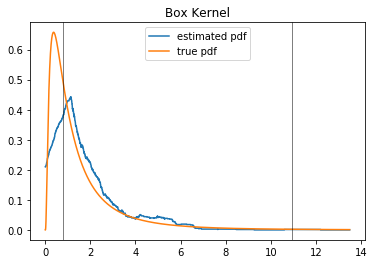

In [6]:
# trim the bids according to equation 6 in paper
v_est_flat = b_flat.squeeze() + 1/(I-1) * np.divide(b_flat_typedf, b_flat_pdf)
v_est_flat = np.multiply(v_est_flat, b_flat_mask)
v_est_flat = v_est_flat[np.isinf(v_est_flat, where=False)]

bandwidth_f = 1.06 * np.std(v_est_flat) * math.pow(v_est_flat.size, -1/5)
v_dist_est = FFTKDE(kernel='box', bw=bandwidth_f).fit(v_est_flat)

X = np.arange(0, 20, step)
f_pdf_est = v_dist_est.evaluate(X)
true_pdf = f_dist.pdf(X)
plt.plot(X[:13500], f_pdf_est[:13500], label='estimated pdf')
plt.plot(X[:13500], true_pdf[:13500], label='true pdf')

f_lower_bound = np.min(v_est_flat) + bandwidth_f
f_upper_bound = np.max(v_est_flat) - bandwidth_f

plt.axvline(x=f_lower_bound, linewidth=0.5, color='black')
plt.axvline(x=f_upper_bound, linewidth=0.5, color='black')
plt.title('Box Kernel')
plt.legend()
plt.show()

Import the Michigan auction data here and transform them into a vector of bids.

In [7]:
import glob
import pandas as pd
data_path = 'data'
# they capitalize csv for some reason...
all_bid_files = glob.glob(data_path + '/**/*.CSV', recursive=True)
dfs = (pd.read_csv(f) for f in all_bid_files)
bid_table_full = pd.concat(dfs, ignore_index=True)

In [8]:
bid_table_full.head()

Bid Open Location Bid Open Date Bid Open Time      Sale Name  \
0  Plainwell Office-WILD    11/28/2017      11:00 AM  Sheridan Road   
1  Plainwell Office-WILD    11/28/2017      11:00 AM  Sheridan Road   
2  Plainwell Office-WILD    11/28/2017      11:00 AM  Sheridan Road   
3  Plainwell Office-WILD    11/28/2017      11:00 AM  Sheridan Road   
4  Plainwell Office-WILD    11/28/2017      11:00 AM  Sheridan Road   

      Sale # No Bid Sale Bid/Non-Bid Species      Species    Product Units  \
0  24-001-17         NaN                 Bid  Sugar Maple  Sawtimber   MBF   
1  24-001-17         NaN                 Bid    Red Maple  Sawtimber   MBF   
2  24-001-17         NaN                 Bid      Red Oak  Sawtimber   MBF   
3  24-001-17         NaN                 Bid    White Oak  Sawtimber   MBF   
4  24-001-17         NaN                 Bid  B. T. Aspen  Sawtimber   MBF   

   Estimated Volume  Appraised Value Per Unit  \
0               6.6                     205.0   
1              31.0                     117.0   
2              47.5                     197.0   
3              10.4                      57.0   
4             110.1                     106.0   

                         Bidder Name  Bid Per Unit  Highest  
0   Packaging Corporation Of America         650.0  HIGHEST  
1   Packaging Corporation Of America         649.0  HIGHEST  
2   Packaging Corporation Of America         650.0  HIGHEST  
3   Packaging Corporation Of America         700.0  HIGHEST  
4   Packaging Corporation Of America         135.5  HIGHEST

Let's do some processing on the raw csv data.
* Combine species and product to create a good for bid
* Rename bid per unit to bid
* Assume information like bid data, bid time do not factor into bidding, and drop them

In [9]:
bid_table_full["Commodity"] = bid_table_full.Species + ' ' + bid_table_full.Product
bid_table_full = bid_table_full.rename(columns={'Bid Per Unit': 'Bid'})
bid_table_full = bid_table_full.loc[bid_table_full['Bid/Non-Bid Species'] == 'Bid']
bid_table = bid_table_full.loc[bid_table_full['No Bid Sale'] != 'NO BID SALE']
bid_table = bid_table[['Sale #', 'Commodity', 'Bid']].dropna()

In [10]:
bid_table.head()

Sale #              Commodity    Bid
0  24-001-17  Sugar Maple Sawtimber  650.0
1  24-001-17    Red Maple Sawtimber  649.0
2  24-001-17      Red Oak Sawtimber  650.0
3  24-001-17    White Oak Sawtimber  700.0
4  24-001-17  B. T. Aspen Sawtimber  135.5

Finally, we estimate the value distribution for different kinds of products.

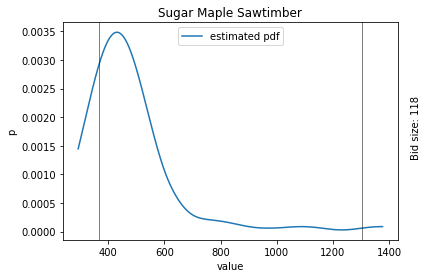

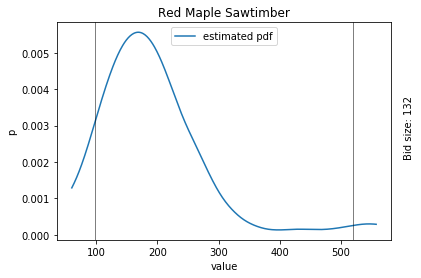

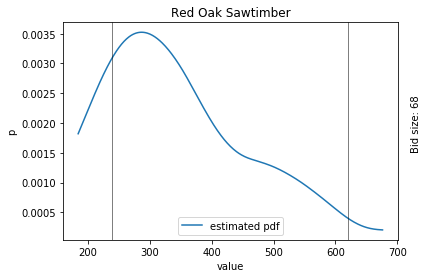

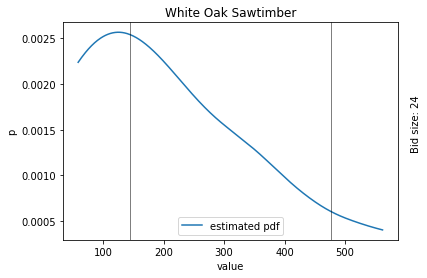

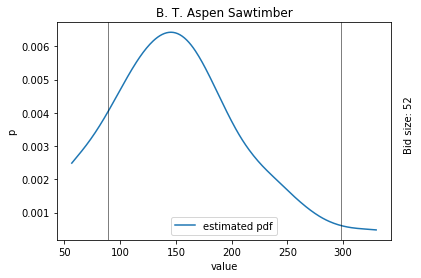

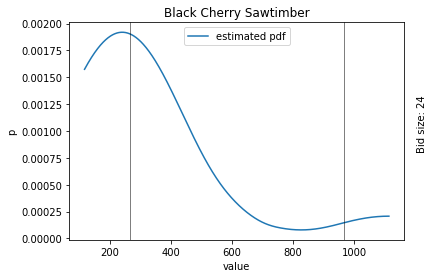

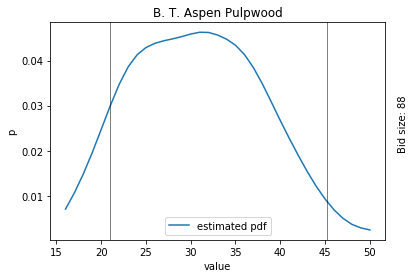

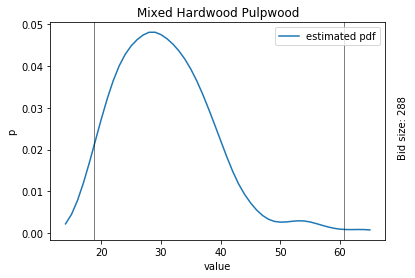

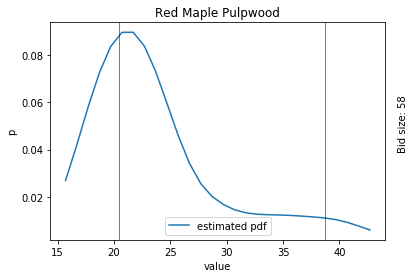

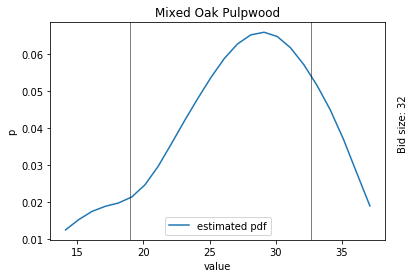

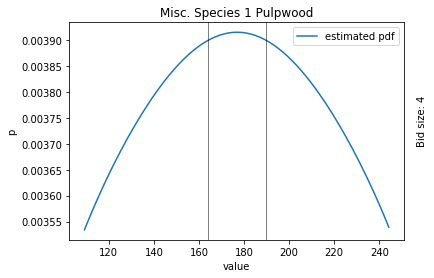

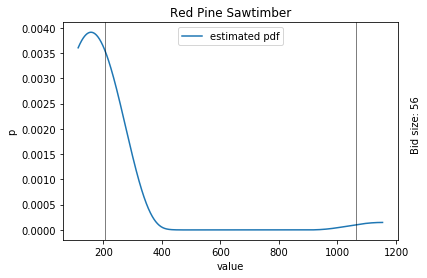

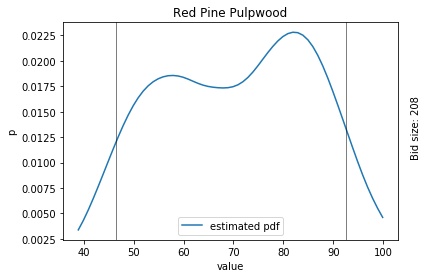

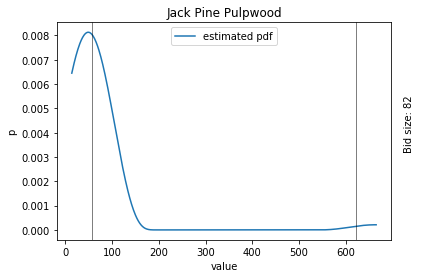

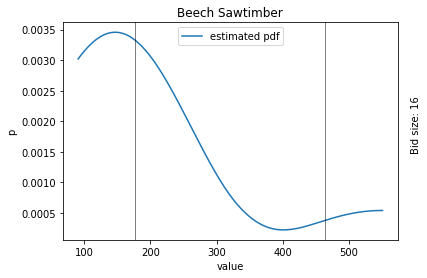

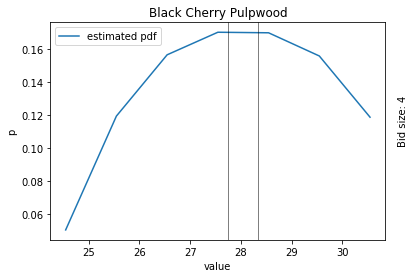

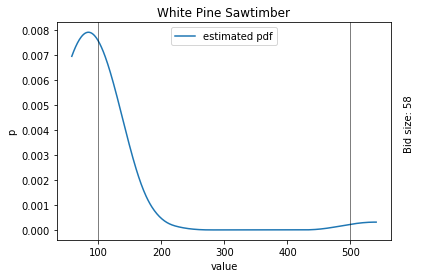

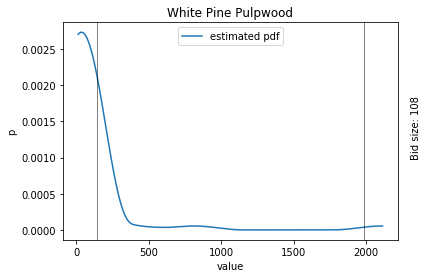

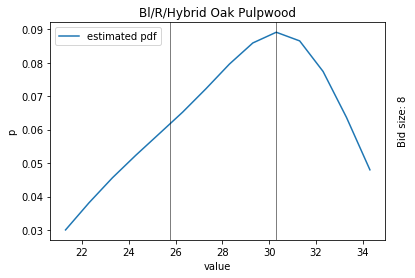

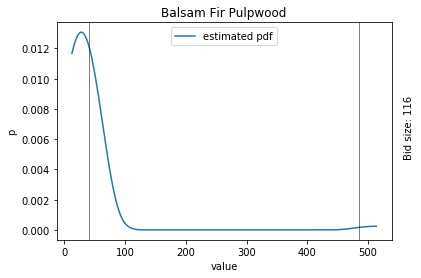

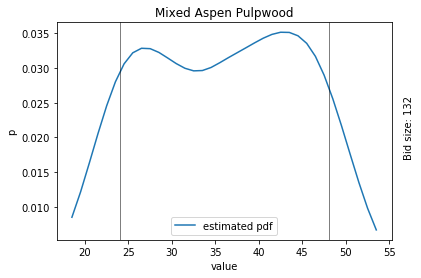

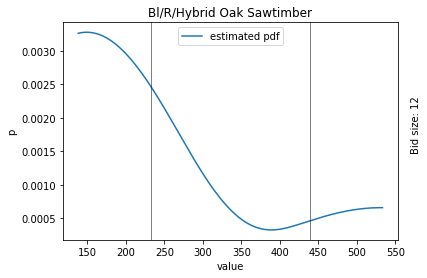

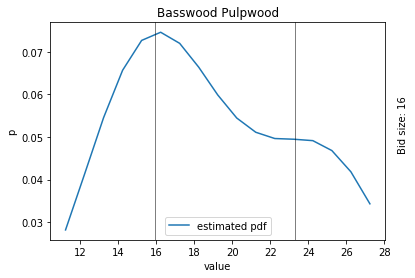

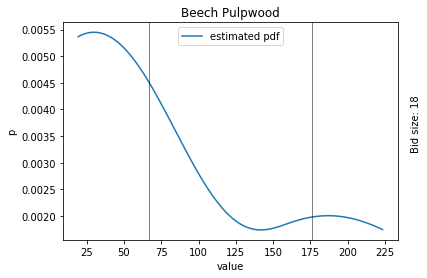

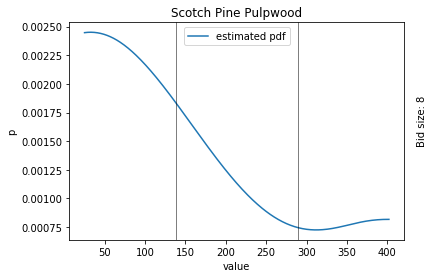

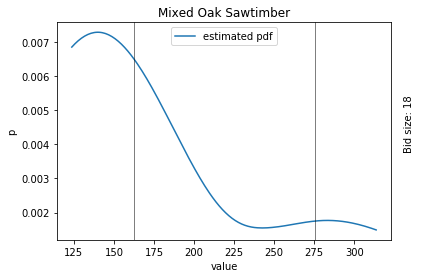

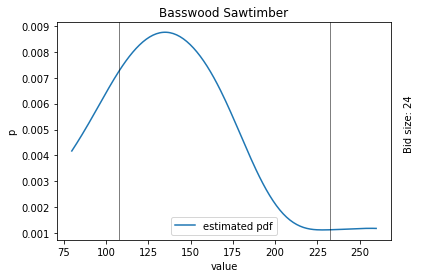

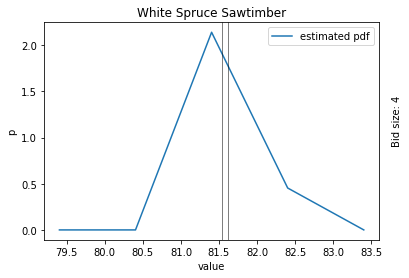

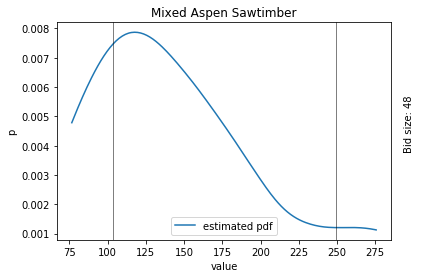

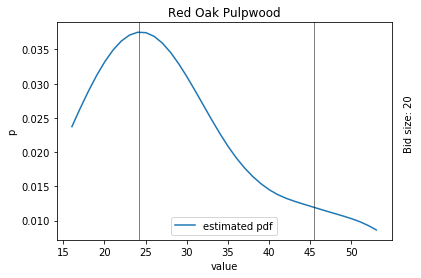

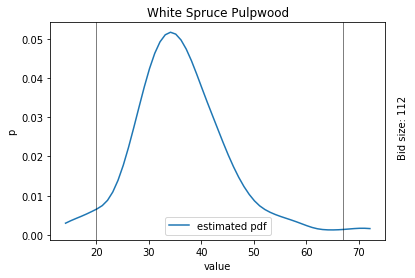

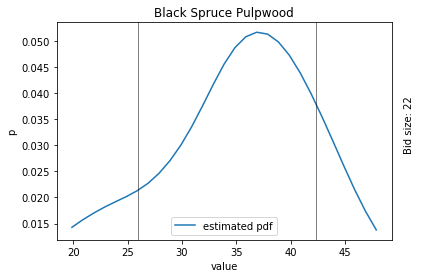

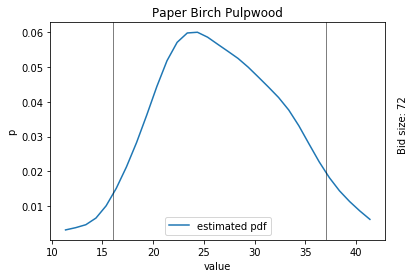

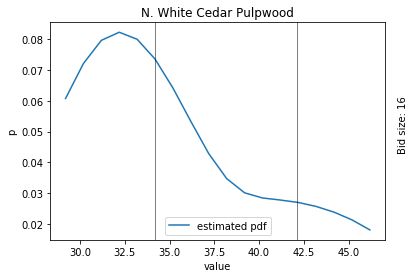

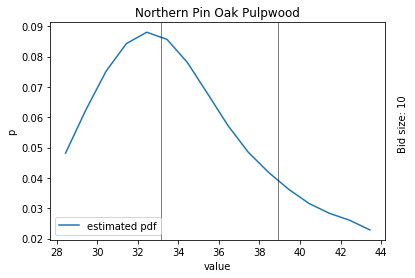

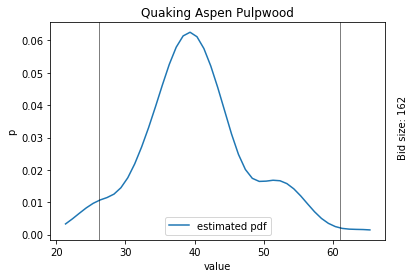

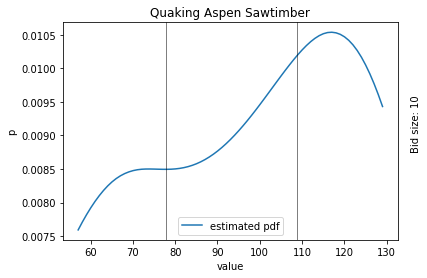

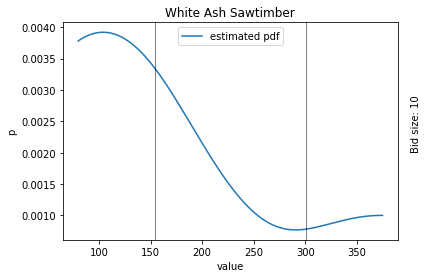

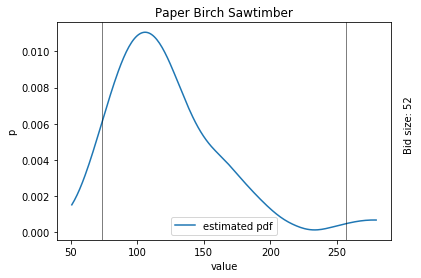

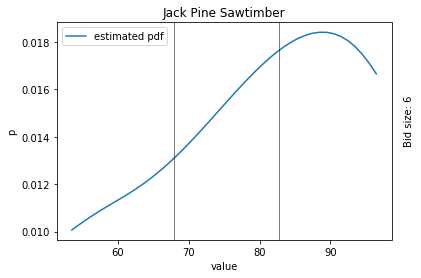

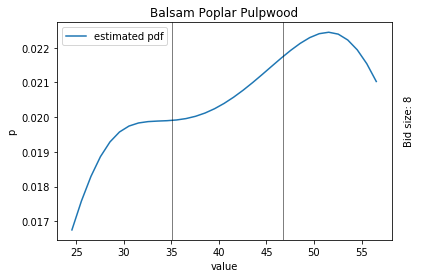

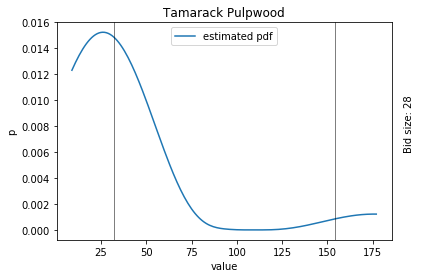

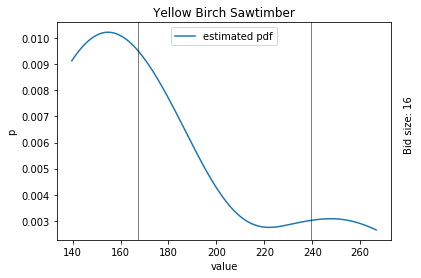

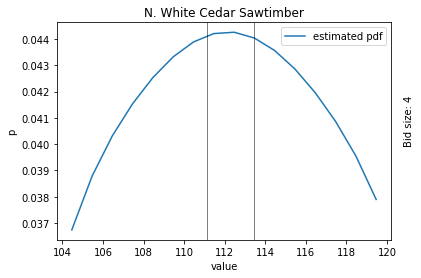

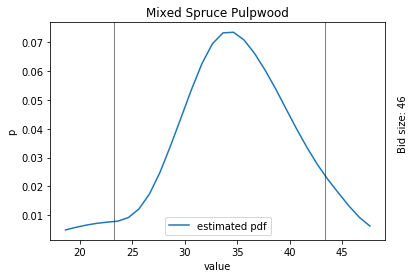

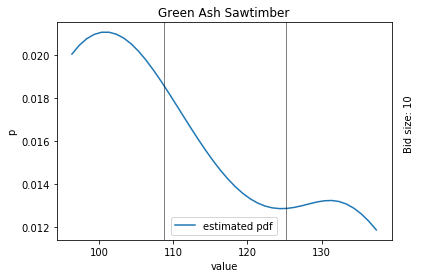

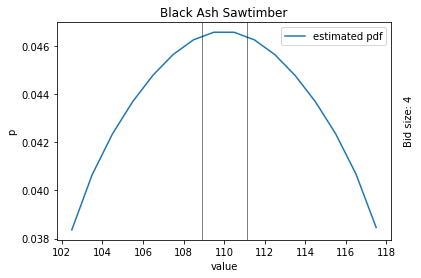

In [11]:
# repeat above procedure for a specific commodity
step = 1
wood_types = bid_table['Commodity'].unique()
for wood in wood_types:
    bid_total = bid_table.loc[bid_table['Commodity'] == wood]
    bid_sales_nums = bid_total["Sale #"].unique()
    values = [[]]
    for sale in bid_sales_nums:
        bids = bid_total.loc[bid_total['Sale #'] == sale].Bid.values
        I = bids.size
        if np.std(bids) > 0:
            b_min = np.min(bids)
            b_max = np.max(bids)

            # estimate bid distribution
            bandwidth_g = 1.06 * np.std(bids) * math.pow(bids.size, -1/5)
            b_dist_est = FFTKDE(kernel='triweight', bw=bandwidth_g).fit(bids)
            b_pdf_est = b_dist_est.evaluate(np.arange(b_min-step-1, b_max+step+1, step))
            b_cdf_est = (b_pdf_est * step).cumsum()

            b_ind = ((bids - (b_min-step-1)) / step).astype(int)
            b_pdf = b_pdf_est[b_ind]
            b_cdf = b_cdf_est[b_ind]

            b_lower = b_min + bandwidth_g
            b_upper = b_max - bandwidth_g
            b_mask = np.where(np.logical_and(bids <= b_upper, \
                                                        bids >= b_lower), 1, np.inf)
            
            # get value from equation
            v = bids.squeeze() + 1/(I-1) * np.divide(b_cdf, b_pdf)
            v = np.multiply(v, b_mask)
            v = v[np.isfinite(v)]
            values.append(v)
    v = np.concatenate(values)
    if v.size > 0 and np.std(v) > 0:
        bandwidth_f = 1.06 * np.std(v) * math.pow(v.size, -1/5)
        v_dist = FFTKDE(kernel='triweight', bw=bandwidth_f).fit(v)

        X = np.arange(np.min(v) - step - 1, np.max(v) + step + 1, step)
        f_pdf_est = v_dist.evaluate(X)
        plt.plot(X, f_pdf_est, label='estimated pdf')

        f_lower = np.min(v) + bandwidth_f
        f_upper = np.max(v) - bandwidth_f

        plt.axvline(x=f_lower, linewidth=0.5, color='black')
        plt.axvline(x=f_upper, linewidth=0.5, color='black')
        plt.title(wood)
        plt.xlabel('value')
        plt.ylabel('p')
        plt.figtext(0.93, 0.6, 'Bid size: {0}'.format(v.size), rotation='vertical')
        plt.legend()
        plt.show()